**Tijuana house prediction price**

In [357]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from geopy.distance import geodesic
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import  r2_score
from scipy.stats import skew #for some statistics
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [358]:
url = 'https://raw.githubusercontent.com/IvanVC21/Tijuana-house-prices/main/tijuana_prices.csv'
df = pd.read_csv(url)

In [359]:
df.head()

,price,currency,bedrooms,bathrooms,parkingSpots,propertySize,neighborhood,lat,lon
0,150000.0,USD,4.0,2.0,3.0,130.0,"Las Americas, Tijuana",32.500975,-116.896457
1,774900.0,USD,3.0,3.0,2.0,550.0,"Hacienda Agua Caliente, Tijuana",32.488683,-116.999223
2,3000000.0,MN,3.0,2.0,2.0,107.0,"Lomas de La Presa, Tijuana",32.448786,-116.924895
3,385000.0,USD,4.0,3.0,3.0,350.0,"Xicotencatl Leyva, Tijuana",32.538363,-116.931519
4,70000.0,USD,2.0,1.0,1.0,80.0,"Vaim, Tijuana",32.493642,-116.942191


In [360]:
#Here, we verify the dimensions of the dataframe df
df.shape

(888, 9)

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         887 non-null    float64
 1   currency      887 non-null    object 
 2   bedrooms      877 non-null    float64
 3   bathrooms     867 non-null    float64
 4   parkingSpots  799 non-null    float64
 5   propertySize  885 non-null    float64
 6   neighborhood  888 non-null    object 
 7   lat           888 non-null    float64
 8   lon           888 non-null    float64
dtypes: float64(7), object(2)
memory usage: 62.6+ KB


In [362]:
df_price = df.copy()

**Note that the currency is in Mexican peso unit. Here, we turn it into USD**

In [363]:
mask = df_price['currency'] == 'MN'
df_price['price'] = np.where(mask,df_price['price']/20,df_price['price'])
df_price.drop('currency', axis=1, inplace=True)

In [364]:
df_price.head()

,price,bedrooms,bathrooms,parkingSpots,propertySize,neighborhood,lat,lon
0,150000.0,4.0,2.0,3.0,130.0,"Las Americas, Tijuana",32.500975,-116.896457
1,774900.0,3.0,3.0,2.0,550.0,"Hacienda Agua Caliente, Tijuana",32.488683,-116.999223
2,150000.0,3.0,2.0,2.0,107.0,"Lomas de La Presa, Tijuana",32.448786,-116.924895
3,385000.0,4.0,3.0,3.0,350.0,"Xicotencatl Leyva, Tijuana",32.538363,-116.931519
4,70000.0,2.0,1.0,1.0,80.0,"Vaim, Tijuana",32.493642,-116.942191


In [365]:
df_price.describe()

,price,bedrooms,bathrooms,parkingSpots,propertySize,lat,lon
count,8.870000e+02,877.000000,867.000000,799.000000,885.000000,888.000000,888.000000
mean,2.350548e+05,3.052452,2.438293,2.445557,259.010169,32.496347,-117.008395
std,3.066921e+05,0.920087,1.244595,7.107074,848.497535,0.029580,0.067410
min,8.250000e+03,1.000000,1.000000,1.000000,1.000000,32.389551,-117.123031
25%,8.600000e+04,3.000000,2.000000,2.000000,102.000000,32.483423,-117.038247
50%,1.540000e+05,3.000000,2.000000,2.000000,138.000000,32.511290,-117.038247
75%,2.825000e+05,3.000000,3.000000,2.000000,225.000000,32.514947,-116.977558
max,3.950000e+06,12.000000,15.000000,200.000000,15976.000000,32.559473,-116.733438


In [366]:
df_price.isnull().sum()

price            1
bedrooms        11
bathrooms       21
parkingSpots    89
propertySize     3
neighborhood     0
lat              0
lon              0
dtype: int64

**Percent of missing data in each column**

In [367]:
missing_data = pd.concat([df_price.isnull().sum(),
                df_price.isnull().mean()*100],
                axis=1,
                keys=["Missing_Data","Percent"]
                )
missing_data = missing_data.sort_values("Percent", 
                                        ascending=False,
                                        )
missing_data

,Missing_Data,Percent
parkingSpots,89,10.022523
bathrooms,21,2.364865
bedrooms,11,1.238739
propertySize,3,0.337838
price,1,0.112613
neighborhood,0,0.000000
lat,0,0.000000
lon,0,0.000000


**Preprocessing data**:

We replace the null data in the columns by the median or mode according to the meaning of the column (numeric or categorical data).

In [368]:
df_price['parkingSpots'].fillna(0,inplace=True)
df_price['bathrooms'].fillna(df_price['bathrooms'].mode().iloc[0],inplace=True)
df_price['bedrooms'].fillna(df_price['bedrooms'].mode().iloc[0],inplace=True)
df_price['propertySize'].fillna(df_price['propertySize'].median(),inplace=True)
df_price['price'].fillna(df_price['price'].median(),inplace=True)
df_price['price'].fillna(df_price['price'].median(),inplace=True)

**Determine the price average according to the number of parkingSpots**

In [369]:
(df_price
    .groupby('parkingSpots')['price']
    .apply(lambda x: x.mean())
    .sort_values(ascending=False)
)
#Note the presence of an outlier in the last raw because it is inconsistence that an 
# house that has the highest number of parking spost
#is the cheapiest  

parkingSpots
7.0      2.465000e+06
6.0      6.530000e+05
20.0     6.500000e+05
5.0      6.418043e+05
8.0      4.760000e+05
4.0      4.042581e+05
3.0      4.006161e+05
0.0      2.527432e+05
10.0     2.150000e+05
2.0      2.011418e+05
1.0      8.142765e+04
200.0    1.400000e+04
Name: price, dtype: float64

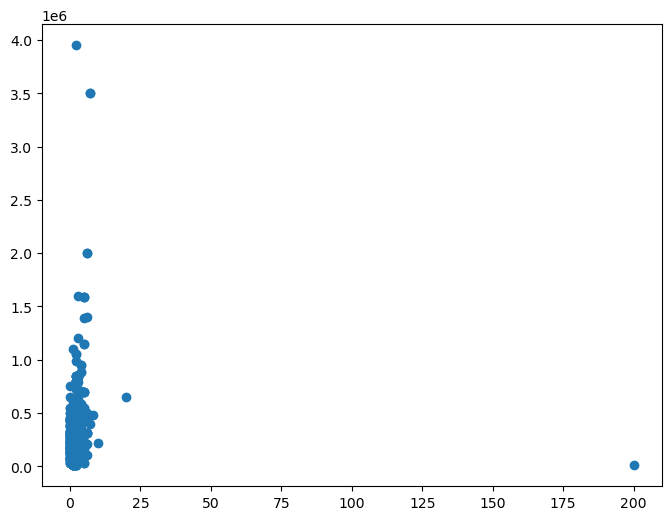

In [370]:
fig = plt.figure(figsize=(8,6))
plt.scatter(df_price['parkingSpots'],df_price['price'])
plt.show()
#The plot allows to distinguish some outliers.
# #

**Histogram of different features**

<Figure size 800x600 with 0 Axes>

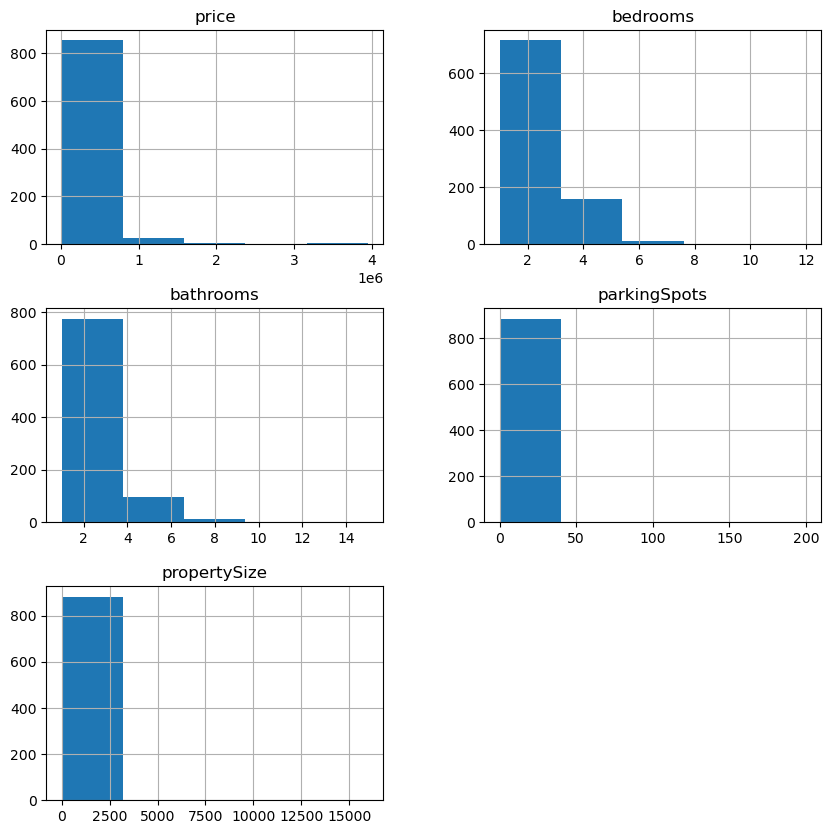

In [371]:
fig = plt.figure(figsize=(8,6))
df_price[['price', 'bedrooms', 'bathrooms','parkingSpots', 'propertySize']].hist(bins = 5,figsize=(10,10))
plt.show()


**Now, we observe the price according to the number of bedrooms, bathrooms and parkingspots using boxplot**


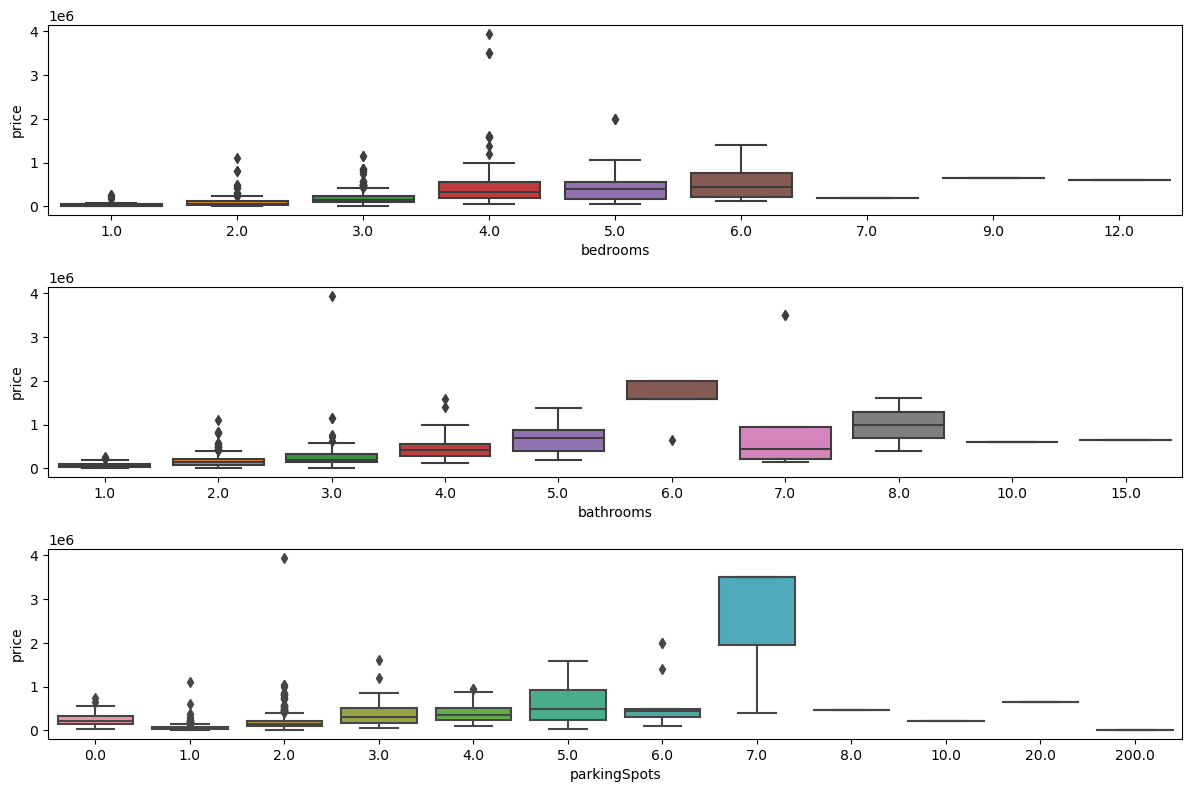

In [372]:
columns = ['bedrooms','bathrooms','parkingSpots']
index = 1
fig = plt.figure(figsize=(12,8))
for col in columns:
    plt.subplot(3,1,index)
    sns.boxplot(x = df_price[col], y  = 'price', data=df_price);
    index = index + 1
fig.tight_layout(pad=1.0)

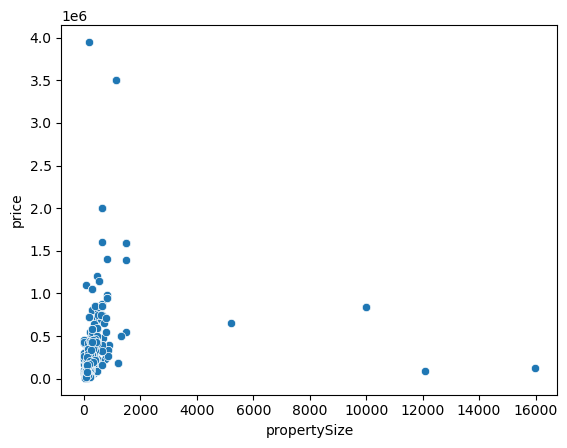

In [373]:
sns.scatterplot(x = df_price['propertySize'], y  = 'price', data=df_price);

Remove outlier

In [374]:
mask_spots = df_price['parkingSpots']>150
mask_Size = df_price['propertySize']>4000

value  = df_price[mask_spots].index.values
col_out = df_price[mask_Size].index.values
df_price.loc[value,'parkingSpots'] = df_price['parkingSpots'].mode().loc[0]

df_price.loc[col_out,'propertySize'] = df_price['propertySize'].median()

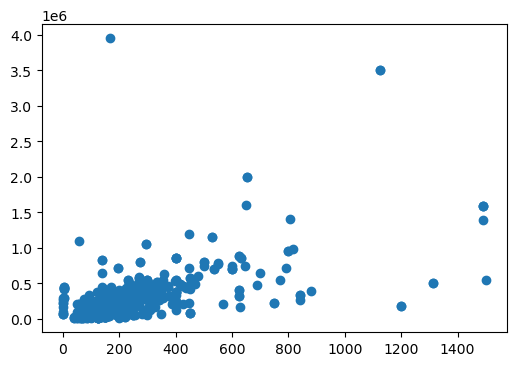

In [375]:
fig = plt.figure(figsize=(6,4))
plt.scatter(df_price.propertySize,df_price.price)
plt.show()

**The correlation between the features**

In [376]:
correlation = df_price.corr().abs()
correlation.where(np.triu(correlation,k=1).astype(np.bool),0)

,price,bedrooms,bathrooms,parkingSpots,propertySize,lat,lon
price,0.0,0.371323,0.543327,0.361825,0.612625,0.023835,0.139960
bedrooms,0.0,0.000000,0.622012,0.325982,0.342538,0.057412,0.087200
bathrooms,0.0,0.000000,0.000000,0.441673,0.447635,0.057402,0.208644
parkingSpots,0.0,0.000000,0.000000,0.000000,0.377456,0.013431,0.063497
propertySize,0.0,0.000000,0.000000,0.000000,0.000000,0.020022,0.051998
lat,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.054947
lon,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [378]:
df_price.head()

,price,bedrooms,bathrooms,parkingSpots,propertySize,neighborhood,lat,lon
0,150000.0,4.0,2.0,3.0,130.0,"Las Americas, Tijuana",32.500975,-116.896457
1,774900.0,3.0,3.0,2.0,550.0,"Hacienda Agua Caliente, Tijuana",32.488683,-116.999223
2,150000.0,3.0,2.0,2.0,107.0,"Lomas de La Presa, Tijuana",32.448786,-116.924895
3,385000.0,4.0,3.0,3.0,350.0,"Xicotencatl Leyva, Tijuana",32.538363,-116.931519
4,70000.0,2.0,1.0,1.0,80.0,"Vaim, Tijuana",32.493642,-116.942191


Now, we verify the skewness of the numeric column *propertySize* and *price*.

In [379]:
col_num = ['propertySize', 'price']
numeric_feature = (df_price[col_num]
                            .apply(lambda x: skew(x))
                            .sort_values(ascending=False)
                  )
skewness = pd.DataFrame(numeric_feature,columns=['Skew'])
skewness

,Skew
price,6.063209
propertySize,3.589284


*price* and *propertySize* are asymmetry. Therefore, we center those features

In [380]:
df_price['propertySize'] = np.log1p(df_price['propertySize']) 
df_price['price'] = np.log1p(df_price['price']) 

**Defining input-output for the training**

In [381]:
y = df_price['price'] 
X = df_price.drop(['price', 'lat','lon'], axis=1)

Coding categorical variables

In [382]:
cat_col = ['bedrooms','bathrooms', 'parkingSpots','neighborhood']

for col in cat_col:
    X[col] = X[col].astype('category')

ohe = OneHotEncoder(sparse = False, drop = 'first')
tf_cat = ohe.fit_transform(X[cat_col])

Scaling numerical column

In [383]:
scaler = RobustScaler()
tf_num = scaler.fit_transform(X.propertySize.values.reshape(-1,1))
X_transform = np.concatenate((tf_num, tf_cat), axis=1)

In [384]:
X_train,X_test,y_train,y_test = train_test_split(X_transform,y,test_size=0.15,random_state=42)
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((754, 211), (134, 211), (754,), (134,))

Now, we use a boosting tecnique that allow us to estimate the price.

Here, we use the hyperparameter optimization with random search and grid search 

In [385]:
import xgboost
regressor=xgboost.XGBRegressor()

In [386]:
base_score=[0.15, 0.2,0.25]

n_estimators = [850, 900, 950]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree']
learning_rate=[0.03, 0.05,0.1]
min_child_weight=[1,2,3,4]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
     }

In [387]:
from sklearn.model_selection import RandomizedSearchCV

random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, 
            n_iter=50,
            scoring = 'neg_mean_absolute_error', 
            n_jobs=4,
            random_state=42
            )
random_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.15, 0.2, 0.25],
                                        'booster': ['gbtree'],
                                        'learning_rate': [0.03, 0.05, 0.1],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [850, 900, 950]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [388]:
best_xgb = random_cv.best_estimator_
best_xgb

XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=900, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

**R2 metrics between predicted and real output value respectively**

In [389]:
y_pred_xgb = best_xgb.predict(X_test)
y_pred_xgb = np.expm1(y_pred_xgb)
y_test_xgb = np.expm1(y_test)
r2 = r2_score(y_test_xgb,y_pred_xgb)
r2

0.8524891877940324

**Using Ridge**

In [390]:
columns=['alpha', 'r2']
df_metric = pd.DataFrame(columns=columns)
alpha_col = [0.1, 0.2,0.5,0.8,1,1.2,1.5] 

for alpha in alpha_col:
    lr  = Ridge(alpha=alpha) 
    lr.fit(X_train,y_train)
    y_test_pred_lr = lr.predict(X_test) 
    y_test_pred_lr = np.expm1(y_test_pred_lr)
    y_test_lr = np.expm1(y_test)
    r2 = r2_score(y_test_lr,y_test_pred_lr)
    row = {columns[0]:alpha,
           columns[1]: r2}
    df_metric = df_metric.append(row, ignore_index=True)

df_metric.sort_values('r2', ascending=False)


,alpha,r2
0,0.1,0.692550
1,0.2,0.692324
2,0.5,0.684631
3,0.8,0.673162
4,1.0,0.665184
5,1.2,0.657414
6,1.5,0.646478


**Lasso**

In [393]:
columns=['alpha', 'r2']
df_metric_Lasso = pd.DataFrame(columns=columns)
alpha_col = [0.1, 0.2,0.5,0.8,1,1.2,1.5] 

for alpha in alpha_col:
    ls  = Lasso(alpha=value) 
    ls.fit(X_train,y_train)
    y_test_pred_ls = lr.predict(X_test) 
    y_test_pred_ls = np.expm1(y_test_pred_ls)
    y_test_ls = np.expm1(y_test)
    r2 = r2_score(y_test_ls,y_test_pred_ls)
    row = {columns[0]:alpha,
           columns[1]: r2}
    df_metric_Lasso = df_metric_Lasso.append(row, ignore_index=True)

df_metric_Lasso.sort_values('r2', ascending=False)


,alpha,r2
0,0.1,0.646478
1,0.2,0.646478
2,0.5,0.646478
3,0.8,0.646478
4,1.0,0.646478
5,1.2,0.646478
6,1.5,0.646478
